A first exploration of the MNIST data set using Flux and a fully connected network 

In [1]:
] activate .

This above command is just to make sure that we are all using the same version of the packages. 

In [2]:
using Flux, Flux.Data.MNIST, Statistics # Our DLNN framework, Some conveniet Data, and Julia's Statistics package
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated # The repeated function makes our training procedure easier, it eliminate looping over the data several times 

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1189


In [3]:
imgs = MNIST.images();

If you try to inspect `imgs` you should see that it is an array of arrays, where each internal array is 2D array containing the image data. To get the the type, you run 
```julia
imgs |> typeof
```
which gives you 
```
Array{Array{Gray{Normed{UInt8,8}},2},1}
```
I use here Julia's [chaining operator `|>`](https://docs.julialang.org/en/v1/base/base/#Base.:|%3E) for convenience, I could have equivalently expressed this at `typeof(imgs)`.
To get the size, we can 
```julia
imgs |> size
```
to get 
```
(60000,)
```
This is a 1D array (i.e. a vector) of 60 thousand images. 

In [4]:
using Images #Not so imporant here

We look at one of the images

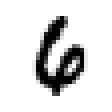

In [5]:
Gray(1)-imgs[40]

Our images are stored as Julia `Gray` image objects. We can, for example, convert the 40th image to floating point array by 
```julia
float(imgs[40])
```
Give it a try and observe the numbers you get. 

In [6]:
X = hcat(float.(reshape.(imgs, :))...);

In the above statement a great deal is happening... lets start from the center, running
```julia 
reshape.(imgs, :)
```
will apply the [`broadcast`](https://docs.julialang.org/en/v1/manual/arrays/index.html#Broadcasting-1) operator to every element in the `img` vector. We now get a vector of vectors, which we convert to floating numbers, via `float` (also doing broadcast with the **\.**) to get vector of floating point vectors. Finally we do horizontal concatenation of the last output to get a one big matrix.  

This is NOT the same as the **design matrix** in our book. Here, each *column* is corresponds to a different example and each *row* corresponds to a feature. 

In [7]:
labels = MNIST.labels();

We get the labels for the MNIST data. They are integers from 0 to 9

,,,,,

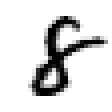
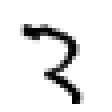
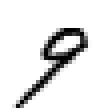
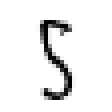
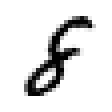
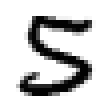

In [8]:
Gray(1).-imgs[500:505]

In [9]:
@show labels[500:505];

labels[500:505] = [8, 3, 9, 5, 8, 5]


In [10]:
Y = onehotbatch(labels, 0:9); 

Applying `onehotbatch` to the labels

In [11]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) 

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

println("Before training")
@show accuracy(X, Y)

dataset = repeated((X, Y), 100)
opt = ADAM(params(m))

@time Flux.train!(loss, dataset, opt)

println("After training")
@show accuracy(X, Y);

Before training
accuracy(X, Y) = 0.07658333333333334
 77.453917 seconds (16.79 M allocations: 48.955 GiB, 35.42% gc time)
After training
accuracy(X, Y) = 0.8979


In [12]:
# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...)
tY = onehotbatch(MNIST.labels(:test), 0:9) 

println("On the test set")
@show accuracy(tX, tY);

On the test set
accuracy(tX, tY) = 0.9044


We really care here about the **accuracy** as measure of how good our model is. However, it is important to now that we used `crossentropy` for training. Why?